In [10]:
# 3-1. 카테고리별 CutPaste ResNet 학습 및 ckpt 저장 (self-supervised)
# 4-1. 학습된 모델에서 512-d feature extractor 확보
# - 입력: 1번/2번 셀에서 준비한 normal_image_paths
# - 출력: 카테고리별 self-supervised CutPaste ResNet 모델, feature extractor, history, ckpt 파일

import os
from datetime import datetime
from pathlib import Path

from jjs.cutpaste_train import train_cutpaste_binary

# -------------------------
# 하이퍼파라미터 설정
# -------------------------
EPOCHS = 100          # 학습 epoch 수
BATCH_SIZE = 64      # 배치 크기
LR = 1e-4            # 학습률
VAL_RATIO = 0.2      # 검증 비율 (0.2 → 80/20 split)
NUM_WORKERS = 4
PRETRAINED = True

# ckpt 저장 경로 (jjs/models/<category>/category_YYYYMMDD_HHMMSS.ckpt)
MODELS_ROOT = os.path.join(PROJECT_ROOT, "jjs", "models")
Path(MODELS_ROOT).mkdir(parents=True, exist_ok=True)

models_by_cat = {}
feature_extractors_by_cat = {}
histories_by_cat = {}

for cat in CATEGORIES:
    paths = normal_image_paths[cat]
    print(f"\n[학습] 카테고리 '{cat}' 정상 이미지 {len(paths)}장으로 CutPaste self-supervised 학습 시작...")

    model_cpcnn, feature_extractor, history = train_cutpaste_binary(
        paths,
        transform=normal_transform,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LR,
        val_ratio=VAL_RATIO,
        num_workers=NUM_WORKERS,
        pretrained=PRETRAINED,
    )

    models_by_cat[cat] = model_cpcnn
    feature_extractors_by_cat[cat] = feature_extractor
    histories_by_cat[cat] = history

    # ckpt 저장
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    cat_dir = os.path.join(MODELS_ROOT, cat)
    Path(cat_dir).mkdir(parents=True, exist_ok=True)
    ckpt_path = os.path.join(cat_dir, f"{cat}_{timestamp}.ckpt")

    torch.save(
        {
            "category": cat,
            "state_dict": model_cpcnn.state_dict(),
            "history": history,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "lr": LR,
            "val_ratio": VAL_RATIO,
        },
        ckpt_path,
    )
    print(f"[저장 완료] {cat} 모델 ckpt → {ckpt_path}")


[학습] 카테고리 'bottle' 정상 이미지 209장으로 CutPaste self-supervised 학습 시작...
총 정상 이미지 개수: 209
 - train: 167장, val: 42장
사용 디바이스: cuda
[Epoch 01] train_loss=0.4094, train_acc=0.793, val_loss=0.4152, val_acc=0.774
[Epoch 02] train_loss=0.1014, train_acc=0.961, val_loss=0.1556, val_acc=0.929
[Epoch 03] train_loss=0.0640, train_acc=0.985, val_loss=0.0358, val_acc=0.988
[Epoch 04] train_loss=0.0246, train_acc=0.991, val_loss=0.0534, val_acc=0.964
[Epoch 05] train_loss=0.0310, train_acc=0.991, val_loss=0.0070, val_acc=1.000
[Epoch 06] train_loss=0.0093, train_acc=1.000, val_loss=0.0345, val_acc=0.976
[Epoch 07] train_loss=0.0063, train_acc=0.997, val_loss=0.0023, val_acc=1.000
[Epoch 08] train_loss=0.0200, train_acc=0.997, val_loss=0.0029, val_acc=1.000
[Epoch 09] train_loss=0.0074, train_acc=1.000, val_loss=0.0053, val_acc=1.000
[Epoch 10] train_loss=0.0189, train_acc=0.994, val_loss=0.0007, val_acc=1.000
[Epoch 11] train_loss=0.0206, train_acc=0.997, val_loss=0.0012, val_acc=1.000
[Epoch 12] train_l

[정보] 메모리에 있는 histories_by_cat 를 사용합니다.


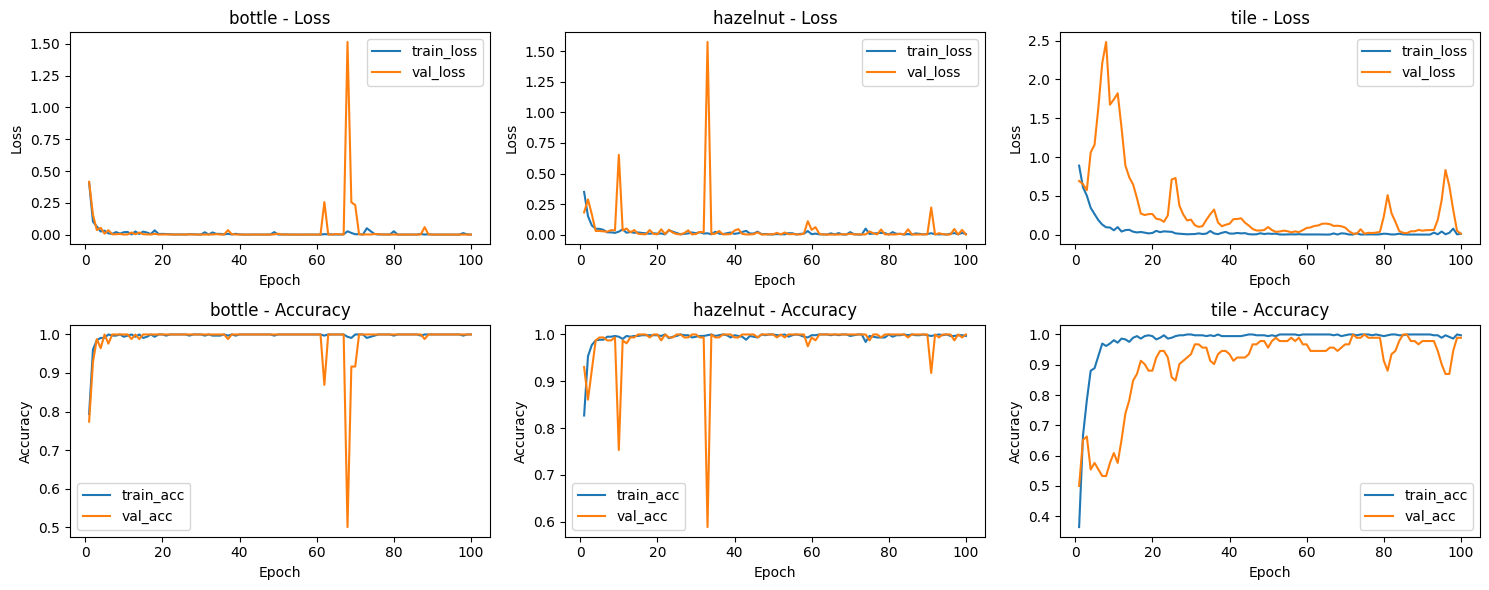

In [ ]:
# 3-2. 카테고리별 self-supervised 학습 곡선 시각화!!
# - 3-1 셀을 다시 돌리지 않아도 되도록,
#   1) 메모리에 histories_by_cat 이 있으면 그대로 사용하고
#   2) 없으면 jjs/models/<cat>/<cat>_*.ckpt 에서 history 를 로드해서 사용합니다.

import os
from glob import glob
import torch
import matplotlib.pyplot as plt

# 1) 우선 메모리에 있는 history 사용
histories = {}
if "histories_by_cat" in globals() and len(histories_by_cat) > 0:
    histories = histories_by_cat
    print("[정보] 메모리에 있는 histories_by_cat 를 사용합니다.")
else:
    print("[정보] 메모리에 histories_by_cat 가 없어 ckpt 에서 history 를 불러옵니다.")
    for cat in CATEGORIES:
        cat_dir = os.path.join(MODELS_ROOT, cat)
        ckpts = sorted(glob(os.path.join(cat_dir, f"{cat}_*.ckpt")))
        if len(ckpts) == 0:
            print(f"[경고] 카테고리 '{cat}' 에 대한 ckpt를 찾을 수 없습니다: {cat_dir}")
            continue
        latest_ckpt = ckpts[-1]
        ckpt = torch.load(latest_ckpt, map_location="cpu")
        history = ckpt.get("history")
        if history is None or len(history.get("epoch", [])) == 0:
            print(f"[경고] ckpt 에 history 정보가 없습니다: {latest_ckpt}")
            continue
        print(f"[불러옴] {cat} history ← {latest_ckpt}")
        histories[cat] = history

if len(histories) == 0:
    print("[경고] 메모리와 ckpt 어디에서도 history 를 찾지 못했습니다.")
else:
    fig, axes = plt.subplots(2, len(CATEGORIES), figsize=(5 * len(CATEGORIES), 6), sharex=False)

    for j, cat in enumerate(CATEGORIES):
        hist = histories.get(cat)
        if hist is None or len(hist.get("epoch", [])) == 0:
            axes[0, j].text(0.5, 0.5, f"No history for {cat}", ha="center", va="center")
            axes[1, j].axis("off")
            continue

        epochs = hist["epoch"]

        # Loss 곡선 (위 행)
        axes[0, j].plot(epochs, hist["train_loss"], label="train_loss")
        axes[0, j].plot(epochs, hist["val_loss"], label="val_loss")
        axes[0, j].set_xlabel("Epoch")
        axes[0, j].set_ylabel("Loss")
        axes[0, j].set_title(f"{cat} - Loss")
        axes[0, j].legend()

        # Accuracy 곡선 (아래 행)
        axes[1, j].plot(epochs, hist["train_acc"], label="train_acc")
        axes[1, j].plot(epochs, hist["val_acc"], label="val_acc")
        axes[1, j].set_xlabel("Epoch")
        axes[1, j].set_ylabel("Accuracy")
        axes[1, j].set_title(f"{cat} - Accuracy")
        axes[1, j].legend()

    plt.tight_layout()
    plt.show()
